In [4]:
from matplotlib import pyplot as plt
import argparse
import imutils
import cv2
import numpy as np

plt.rcParams['figure.figsize'] = [10, 10]

In [5]:
class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)

        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"

        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"

        # return the name of the shape
        return shape

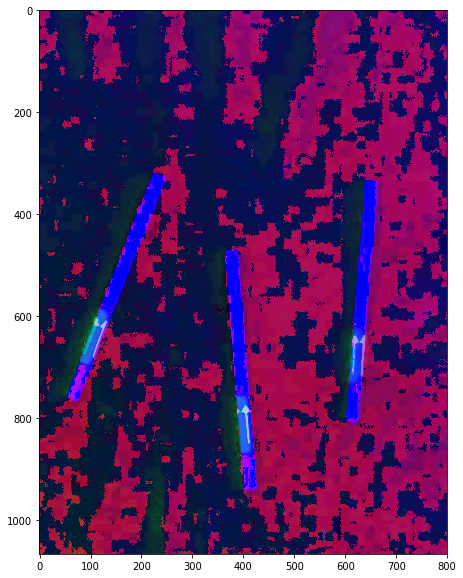

In [101]:
# image = cv2.imread('shapes_and_colors.png')
image = cv2.imread('strips2.jpg')
# image = cv2.imread('strips6.png')
image = cv2.medianBlur(image, 5)

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)

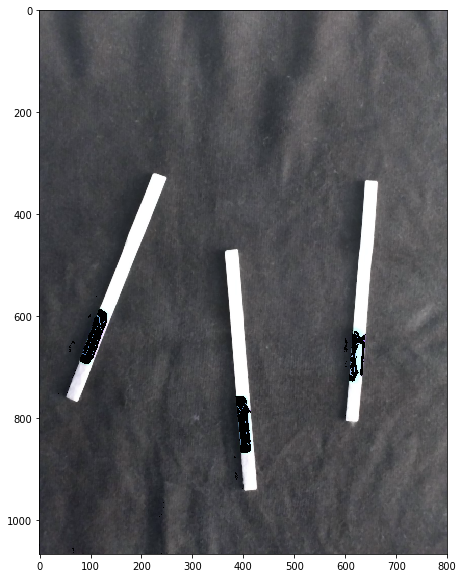

In [102]:
lower_red = np.array([0,50,50]) 
upper_red = np.array([10,255,255]) 
mask1 = cv2.inRange(hsv, lower_red, upper_red) 

lower_red = np.array([170,50,50]) 
upper_red = np.array([180,255,255]) 
mask2 = cv2.inRange(hsv, lower_red, upper_red) 

red_mask = mask1+mask2

lower_green = np.array([20,50,50]) 
upper_green = np.array([90,255,255]) 
green_mask = cv2.inRange(hsv, lower_green, upper_green) 

mask = red_mask + green_mask
# mask = green_mask

res = cv2.bitwise_and(image, image, mask = mask) 
# plt.imshow(mask) 
plt.imshow(res) 

image[np.where((res!=[0, 0, 0]).all(axis=2))] = [0, 0, 0]
plt.imshow(image) 

# np.where((mask==[1]).all(axis=2))



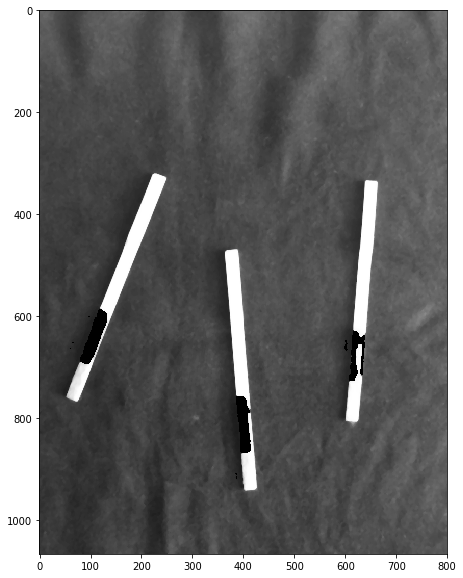

In [103]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.medianBlur(image, 5)
plt.imshow(image, cmap='gray')

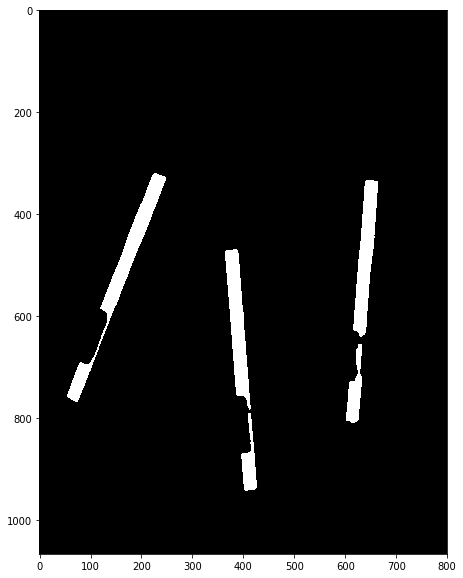

In [104]:
ret,thresh1 = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray')

# thresh2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
# plt.imshow(thresh2, cmap='gray')

# thresh3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# plt.imshow(thresh3, cmap='gray')

In [105]:
# load the image and resize it to a smaller factor so that
# the shapes can be approximated better
resized = imutils.resize(thresh1, width=300)
ratio = image.shape[0] / float(resized.shape[0])

In [106]:
# convert the resized image to grayscale, blur it slightly,
# and threshold it
# gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
gray = resized
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

In [107]:
# find contours in the thresholded image and initialize the
# shape detector
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

print("Detected",len(cnts),"shapes")

Detected 5 shapes


triangle
triangle
circle
circle
circle


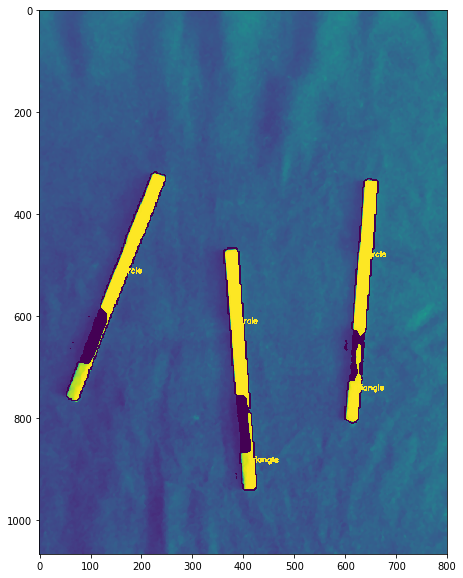

In [108]:
# loop over the contours
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    
    if M["m00"] == 0: continue
    
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape = sd.detect(c)

    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
    cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    
    print(shape)

# show the output image
plt.imshow(image)